In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
#%pdb

<IPython.core.display.Javascript object>

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy, sws_replace
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets, get_layer_data
from retrain_layer import retrain_layer
retraining_epochs = 50


test_data_full = Variable(test_data(fetch = "data")).cuda()
test_labels_full = Variable(test_data(fetch = "labels")).cuda()
val_data_full = Variable(search_validation_data(fetch = "data")).cuda()
val_labels_full = Variable(search_validation_data(fetch = "labels")).cuda()


In [22]:
#1. Train all 3 layers
#2. Unify model and replace priors
#3. Optimize as usual
def layer_retrain_LeNet_300_100(mean, zmean, temp, tau, mixtures, data_size, loss_type = 'MSEHNA', savedir = ''):
    zvar = 10
    var = 2
    model_name = 'LeNet_300_100'
    
    #train 3 layers independently
    layer_model_1, gmp_1, res_1 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 1, data_size, model_name, loss_type, savedir)
    layer_model_2, gmp_2, res_2 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 2, data_size, model_name, loss_type, savedir)
    layer_model_3, gmp_3, res_3 = retrain_layer(mean, var, zmean, zvar, mixtures, temp, tau, 3, data_size, model_name, loss_type, savedir)

    #transfer GMP to new unified model architecture
    unified_model = sws_replace(model_archs.LeNet_300_100().cuda(), [layer_model_1.state_dict(), layer_model_2.state_dict(), layer_model_3.state_dict()])
    gmp_u1 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc1.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_1.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u2 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc2.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_2.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u3 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc3.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_3.means.clone().data.cpu().numpy(), scaling = False)

    #load datasets
    data_size = 'search'
    if(data_size == 'search'):
        train_dataset = search_train_data()
        val_data_full = Variable(test_data(fetch='data')).cuda()
        val_labels_full = Variable(test_data(fetch='labels')).cuda()
        un_val_acc = test_accuracy(val_data_full, val_labels_full, unified_model)[0]
    if(data_size == 'full'):
        train_dataset = train_data()

    loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_data_full = Variable(test_data(fetch='data')).cuda()
    test_labels_full = Variable(test_data(fetch='labels')).cuda()
    
    
    #unified accuracy
    unify_res = plot_data(unified_model, mode = 'retrain', data_size = data_size, loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures)
    unify_res.data_epoch(0, unified_model)
    
    #init optimizers
    loss_type = 'CESNT'
    opt_1 = torch.optim.Adam([
            {'params': unified_model.fc1.parameters(), 'lr': 1e-4},
            {'params': [gmp_u1.means], 'lr': 3e-4},
            {'params': [gmp_u1.gammas, gmp_u1.rhos], 'lr': 3e-3}])
    opt_2 = torch.optim.Adam([
            {'params': unified_model.fc2.parameters(), 'lr': 1e-4},
            {'params': [gmp_u2.means], 'lr': 3e-4},
            {'params': [gmp_u2.gammas, gmp_u2.rhos], 'lr': 3e-3}])
    opt_3 = torch.optim.Adam([
            {'params': unified_model.fc3.parameters(), 'lr': 1e-4},
            {'params': [gmp_u3.means], 'lr': 3e-4},
            {'params': [gmp_u3.gammas, gmp_u3.rhos], 'lr': 3e-3}])

    #align and retrain
    show_sws_weights(unified_model)
    for epoch in range(30):
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u1, opt_1, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u2, opt_2, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u3, opt_3, loader, tau, 1, loss_type)
        #test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
        #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
        #model_n, means = clamp_weights (model_n, means)
        unify_res.data_epoch(epoch+1, unified_model)
        
        if (trueAfterN(epoch, 10)):
            print ("Epoch: {}, Test Acc: {:.2f}".format(epoch+1, unify_res.test_accuracy[-1]))
    show_sws_weights(unified_model)

    #prune model
    l1_prune = sws_prune(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    
    ures = unify_res.gen_dict()

    show_sws_weights(pruned_model)
    res_test = test_accuracy(res_stats.test_data_full, res_stats.test_labels_full, unified_model)
    ures['compress_test'] = res_test[0]
    ures['prune_test'] = res_test[2]
    ures['sparsity'] = res_test[3]
    if (data_size == "search"):
        res_val = layer_accuracy(res_stats.val_data_full, res_stats.val_labels_full, unified_model)
        res['prune_val'] = res_val[2]
        res['compress_val'] = res_val[0]
    
    return layer_model_1, gmp_1, res_1, layer_model_2, gmp_2, res_2, layer_model_3, gmp_3, res_3, unified_model, ures

In [ ]:
_, _, r1, _, _, r2, _, _, r3, _, ru = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-7, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = '')

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0


In [ ]:
savedir = './expfiles/'

In [ ]:

model_n = copy.deepcopy(prune_model)
data_size = 'search'
if(data_size == 'search'):
    train_dataset = search_train_data()
if(data_size == 'full'):
    train_dataset = train_data()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_n.parameters(), lr=2e-5, weight_decay = 0.000)
gmp_list = [gmp_1, gmp_2, gmp_3]
means = np.concatenate([x.means.clone().data.cpu().numpy() for x in gmp_list] + np.array([0]))

for epoch in range(20):
    model_n, loss = train_epoch(model_n, optimizer, criterion, train_loader)

    test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
    #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

    model_n, means = clamp_weights (model_n, means)
    if (trueAfterN(epoch, 10)):
        test_acc = test_accuracy(val_data_full, val_labels_full, model_n)
        print('Clamped Training - Epoch: {}. Test Accuracy: {:.2f} - Sparsity: {:.2f}'.format(epoch+1, test_acc[0], get_sparsity(model_n)))
        #show_sws_weights(model_n)
    #print (get_sparsity(model_n))
clamped_val = test_accuracy(val_data_full, val_labels_full, model_n)
clamped_sp = get_sparsity(model_n)
res_str += "- Clamped Acc: {:.2f} Clamped Sp: {:.2f}\n".format(clamped_val[0], clamped_sp)
overall_res += res_str

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.00


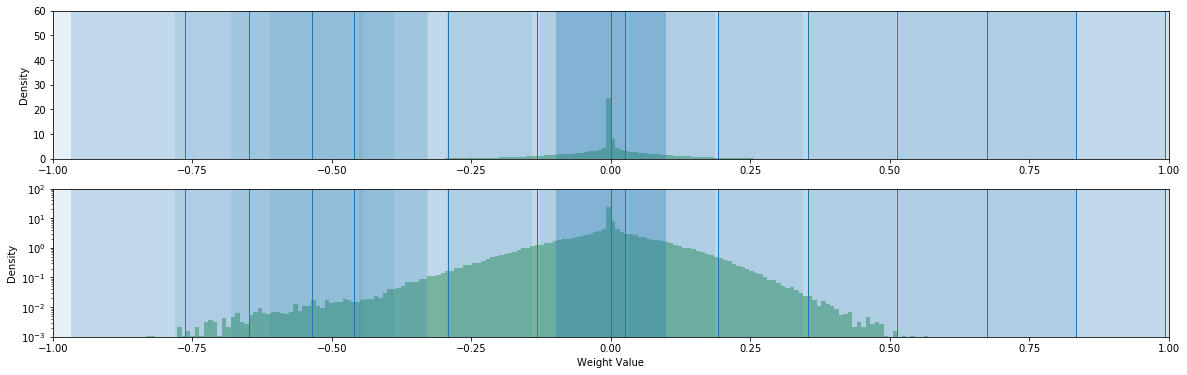

Original: 98.26% - Retrain: 98.28% - Prune: 98.03% - Quantize: 98.07% - Sparsity: 50.79%
Epoch: 50. Loss: 0.00


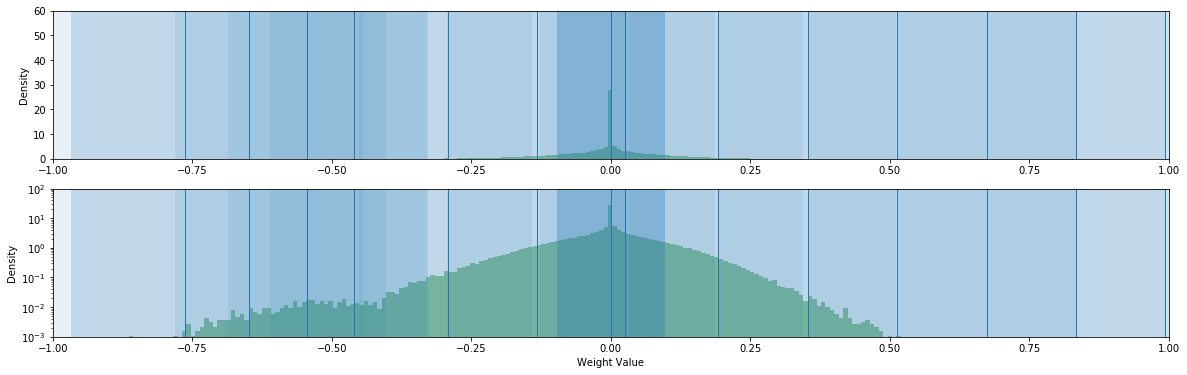

Original: 98.26% - Retrain: 98.29% - Prune: 98.04% - Quantize: 98.05% - Sparsity: 51.51%
Original: 98.15% - Retrain: 98.12% - Prune: 97.99% - Quantize: 98.03% - Sparsity: 51.51%
Original: 98.26% - Retrain: 98.29% - Prune: 98.04% - Quantize: 98.05% - Sparsity: 51.51%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.00


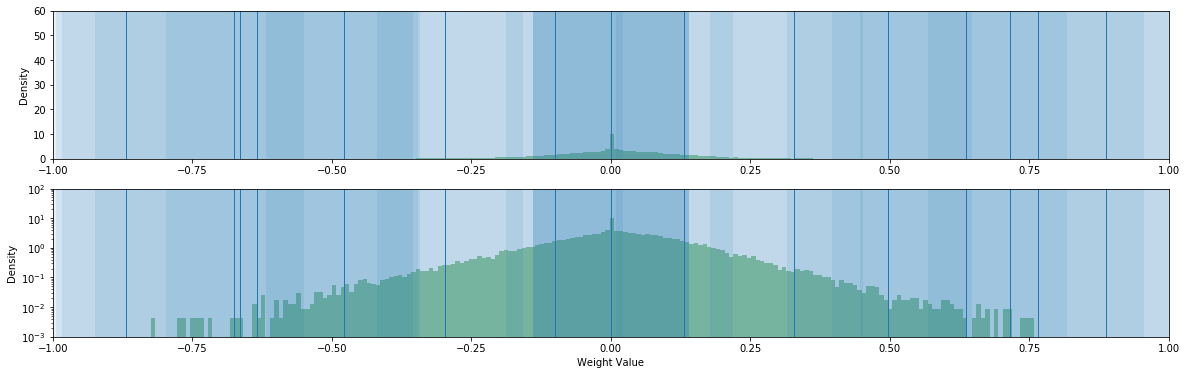

Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.09%
Epoch: 50. Loss: 0.00


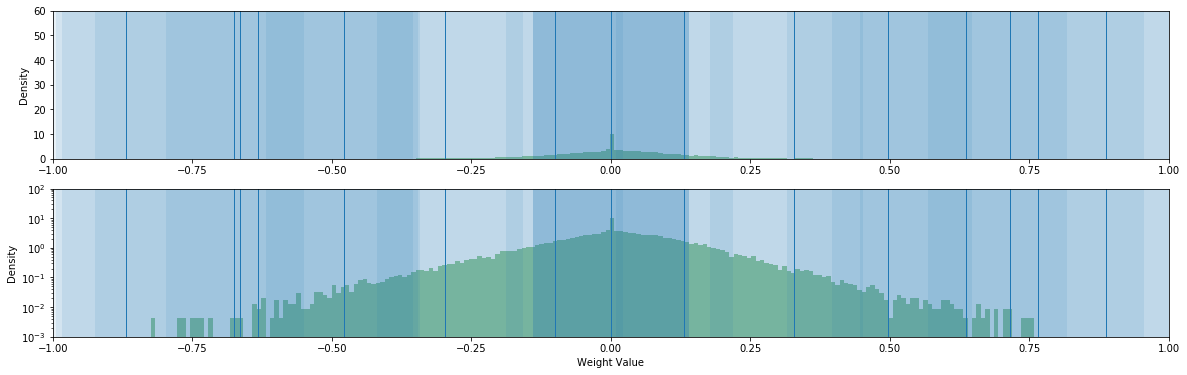

Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.16%
Original: 98.15% - Retrain: 98.15% - Prune: 98.16% - Quantize: 98.08% - Sparsity: 42.16%
Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.16%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0


In [ ]:
overall_res = ""
for mean in [10, 100, 1000, 10000]:
    for zmean in [10, 100, 1000, 10000]:
        res_str = "Mean: {:.2f} ZMean: {:.2f}\n".format(mean,zmean)
        layer_model_1, gmp_1, res_1 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-7, 1, 'MSEHNA')
        layer_model_2, gmp_2, res_2 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-7, 2, 'MSEHNA')
        layer_model_3, gmp_3, res_3 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-8, 3, 'MSEHNA')
        prune_model = sws_replace(model_archs.LeNet_300_100().cuda(), [sws_prune_l2(layer_model_1, gmp_1), sws_prune_l2(layer_model_2, gmp_2), sws_prune_l2(layer_model_3, gmp_3)])
        test_acc = test_accuracy(val_data_full, val_labels_full, prune_model)
        res_str += "Layer 1 Acc: {:.2f}% - Layer 1 Sp: {:.2f} - Layer 2 Acc: {:.2f}% - Layer 2 Sp: {:.2f} - Layer 3 Acc: {:.2f}% - Layer 3 Sp: {:.2f} - Model Acc: {:.2f} - Model Sp: {:.2f}".format(res_1['prune_val'], res_1['sparsity'], res_2['prune_val'], res_2['sparsity'], res_3['prune_val'], res_3['sparsity'], test_acc[0], get_sparsity(prune_model))

        model_n = copy.deepcopy(prune_model)
        data_size = 'search'
        if(data_size == 'search'):
            train_dataset = search_train_data()
        if(data_size == 'full'):
            train_dataset = train_data()

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_data_full = Variable(test_data(fetch='data')).cuda()
        test_labels_full = Variable(test_data(fetch='labels')).cuda()

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_n.parameters(), lr=2e-5, weight_decay = 0.000)
        gmp_list = [gmp_1, gmp_2, gmp_3]
        means = np.concatenate([x.means.clone().data.cpu().numpy() for x in gmp_list] + np.array([0]))

        for epoch in range(20):
            model_n, loss = train_epoch(model_n, optimizer, criterion, train_loader)

            test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
            #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

            model_n, means = clamp_weights (model_n, means)
            if (trueAfterN(epoch, 10)):
                test_acc = test_accuracy(val_data_full, val_labels_full, model_n)
                print('Clamped Training - Epoch: {}. Test Accuracy: {:.2f} - Sparsity: {:.2f}'.format(epoch+1, test_acc[0], get_sparsity(model_n)))
                #show_sws_weights(model_n)
            #print (get_sparsity(model_n))
        clamped_val = test_accuracy(val_data_full, val_labels_full, model_n)
        clamped_sp = get_sparsity(model_n)
        res_str += "- Clamped Acc: {:.2f} Clamped Sp: {:.2f}\n".format(clamped_val[0], clamped_sp)
        overall_res += res_str

print(overall_res)

In [22]:
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
full_model = torch.load(model_load_dir + model_file + ".m")
layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)

Original: 98.26% - Retrain: 97.24% - Prune: 95.52% - Quantize: 94.95% - Sparsity: 97.40%


(97.24, 95.52, 94.95, 97.40382165605097)